In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import pandas as pd
import sys 
import base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random
from sklearn.metrics import accuracy_score, roc_auc_score
from datetime import datetime, timedelta, date
from itertools import combinations
from numpy.linalg import norm
import pickle
import os
import torch.nn as nn
import torch
from torch.nn import Linear
import torch.nn.functional as F
import altair as alt
from altair import expr, datum
from vega_datasets import data
from geopy.geocoders import Nominatim
from tqdm import tqdm
import os
import random
import shutil
import time

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from utils import *
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CyclicLR, ExponentialLR

tqdm.pandas()
DATA_PATH = './data'

important source : https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/

In [3]:
split_total_images_folder(DATA_PATH)

Split has already been done. Exiting...


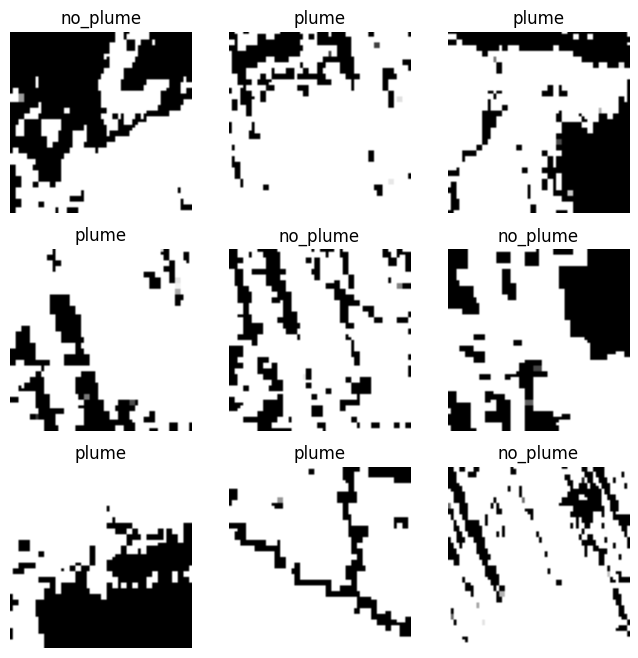

In [4]:
# https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/
image_transforms = { 
    'train': transforms.Compose([
        transforms.Grayscale(),
        # transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
        # transforms.RandomRotation(degrees=15),
        # transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(size=64),
        transforms.ToTensor()
    ]),

    'valid': transforms.Compose([
        transforms.Grayscale(),
        # transforms.Resize(size=64),
        # transforms.CenterCrop(size=64),
        transforms.ToTensor()
    ])
}

data, train_data, val_data, train_data_size, val_data_size = dataset_creation(image_transforms, DATA_PATH, bs=16)

labels_map = {
    0: "no_plume",
    1: "plume"
}
#num classes
num_classes = 2
plot_images(data, labels_map, cols=3, rows=3)

In [5]:
# data foor model (three channels)
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(size=64),
        transforms.ToTensor()
    ]),

    'valid': transforms.Compose([
        transforms.CenterCrop(size=64),
        transforms.ToTensor()
    ])
}

data, train_data, val_data, train_data_size, val_data_size = dataset_creation(image_transforms, DATA_PATH, bs=16)


# Training

In [6]:
def train(DATA_PATH, model, epochs, loss_criterion, optimizer, train_data, val_data, device, model_name, scheduler=None, performances_df=None):
    """train a given model to perform the task

    Args:
        model (pytorch model): the model to train
        epochs (int): number of epochs to train
        loss_criterion (torch.nn): the loss on which perform the training
        optimizer (dataset): the torch optimizer 
        train_data (dataset): the training data
        val_data (dataset): the validation data
        device (str): the device to perform the calculation ('cpu', or 'cuda')
        model_name (str): the name to give to the model_saving file
        scheduler (pandas df, optional): the learning rate scheduler. Defaults to None.
        performances_df (pandas df, optional): If different from None, continue the completion of the given datast. Defaults to None.

    Returns:
        performances_df: the summary of the training
    """
    
    if performances_df == None:
        if scheduler != None:
            performances_df = pd.DataFrame(columns=['epoch', 'lr', 'train_loss', 'val_loss', 'train_accu', 'val_accu', 'train_auc', 'val_auc'])
        else:
            performances_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'train_accu', 'val_accu', 'train_auc', 'val_auc'])
    
    best_loss = np.inf
    
    for epoch in range(epochs):
        epoch_start = time.time()
        # print("Epoch: {}/{}".format(epoch+1, epochs))
        # Set to training mode
        model.train()
        # Loss and Accuracy within the epoch
        train_loss = []
        train_accu = []
        train_auc = []

        val_loss = []
        val_accu = []
        val_auc = []

        for i, (inputs, labels) in enumerate(train_data):
            ################
            ###  TRAIN   ###
            ################
            inputs = inputs.to(device)
            labels = labels.to(device)
            numpy_labels = labels.cpu().bool().numpy()
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            ## LOSS ##

            # Compute loss
            loss = loss_criterion(outputs, labels)
            # Backpropagate the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
            #scheduler
            try:
                scheduler.step() #update the lambda scheduler
            except:
                pass
            # Compute the total loss for the batch and add it to train_loss
            train_loss.append(loss.item())

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            train_accu.append(accuracy_score(numpy_labels,predictions.cpu().bool().numpy()))
            
            #compute auc_roc
            probas_plume = outputs[:,-1:].detach().cpu().numpy()
            try:
                train_auc.append(roc_auc_score(numpy_labels, probas_plume))
            except:
                print('Only one class in y_true !!')
                train_auc.append(0)

            ################
            ###  VALID   ###
            ################
            model.eval()
            with torch.no_grad():
                for i, (inputs, labels) in enumerate(val_data):

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    numpy_labels = labels.cpu().bool().numpy()
                    outputs = model(inputs)

                    # Compute loss
                    loss = loss_criterion(outputs, labels)
                    val_loss.append(loss.item())

                    # Compute the accuracy
                    ret, predictions = torch.max(outputs.data, 1)
                    val_accu.append(accuracy_score(numpy_labels, predictions.cpu().bool().numpy()))
                    
                    #compute auc_roc
                    probas_plume = outputs[:,-1:].detach().cpu().numpy()
                    try:
                        val_auc.append(roc_auc_score(numpy_labels, probas_plume))
                    except:
                        print('Only one class in y_true !!')
                        val_auc.append(0)

        val_loss = np.mean(val_loss)
        try:
            lr = scheduler.get_last_lr()[0]
            for_df_list = [
                        epoch, lr, np.mean(train_loss), val_loss, 
                        np.mean(train_accu), np.mean(val_accu),
                        np.mean(train_auc), np.mean(val_auc)
                        ]
        except:
            lr = scheduler.get_last_lr()[0]
            for_df_list = [
                        epoch, np.mean(train_loss), val_loss, 
                        np.mean(train_accu), np.mean(val_accu),
                        np.mean(train_auc), np.mean(val_auc)
                        ]
        
        performances_df.loc[len(performances_df)] =  for_df_list                                 

        if epoch%10 == 0:
            print(f"Epoch: {epoch:03d} | Train loss: {np.mean(train_loss):.4f} | Val loss: {val_loss:.4f} | Train Accu: { np.mean(train_accu):.4f} | Val Accu: {np.mean(val_accu):.4f} | Train AUC: { np.mean(train_auc):.4f} | Val AUC: { np.mean(val_auc):.4f} ")


        #save best model
        if val_loss < best_loss:
            torch.save(model, DATA_PATH+f'/models/{model.__class__.__name__}_{model_name}.pt')
            best_loss = val_loss

    return performances_df

In [9]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), 
    nn.Softmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to('cpu')

# Define Optimizer and Loss Function
loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=1e-3)
#scheduler
# scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
# scheduler = ExponentialLR(optimizer, gamma=0.7)
scheduler = CyclicLR(optimizer,
            base_lr=1e-8,
            max_lr=1e-3,
            step_size_up=5,
            mode="triangular2",cycle_momentum=False)

performances_df = train(DATA_PATH, resnet50, 20, loss_criterion, optimizer, train_data, val_data, scheduler=scheduler, device='cpu', model_name='pretrained_resnet50_lr1em3')

Epoch: 000 | Train loss: 0.6771 | Val loss: 0.7010 | Train Accu: 0.5941 | Val Accu: 0.5988 | Train AUC: 0.6350 | Val AUC: 0.4403 
Epoch: 010 | Train loss: 0.6786 | Val loss: 0.6505 | Train Accu: 0.5532 | Val Accu: 0.8333 | Train AUC: 0.6229 | Val AUC: 0.8889 


with lr = 1e-3, you got the nice U curve of loss showing the overfit. Lr scheduler to refine, or early stopping

`with scheduler`:
- **StepLR**(optimizer, step_size=4, gamma=0.5) & lr=1e-3: not bad, but still this U shape. Plus the train performance doesn't seem quite good, compared to validation evolution
- **ExponentialLR**(optimizer, gamma=0.7) & lr=1e-3: surprisingly REALLY BAD


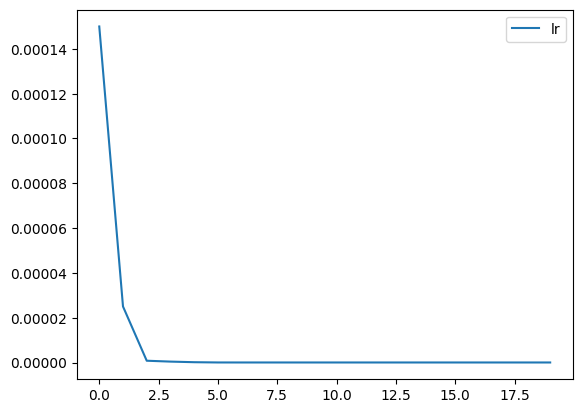

In [10]:
try:
    performances_df[['lr']].plot()
except:
    print('No lr scheduling')

<Axes: >

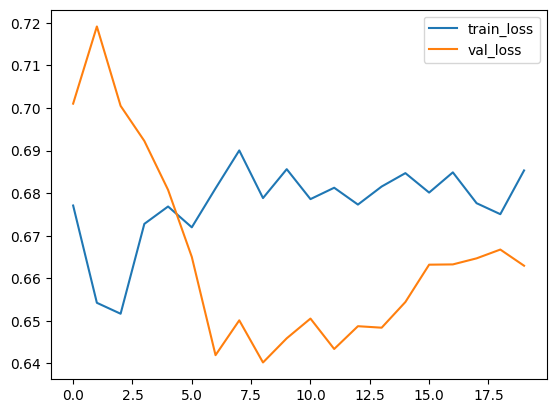

In [11]:
performances_df[['train_loss', 'val_loss']].plot()

(-0.1, 1.1)

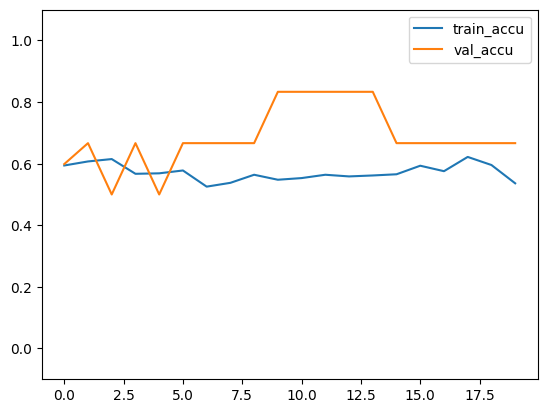

In [14]:
performances_df[['train_accu', 'val_accu']].plot()
plt.ylim(-0.1, 1.1)

(-0.1, 1.1)

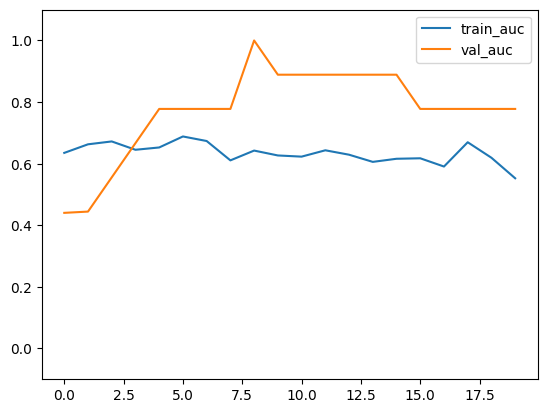

In [15]:
performances_df[['train_auc', 'val_auc']].plot()
plt.ylim(-0.1, 1.1)

#### efficient net

In [ ]:
efficientnet = models.efficientnet_b7(weights='DEFAULT')

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), 
    nn.Softmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to('cpu')

# Define Optimizer and Loss Function
loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=1e-3)
#scheduler
# scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
# scheduler = ExponentialLR(optimizer, gamma=0.7)
scheduler = CyclicLR(optimizer,
            base_lr=1e-8,
            max_lr=1e-3,
            step_size_up=5,
            mode="triangular2",cycle_momentum=False)

performances_df = train(DATA_PATH, resnet50, 20, loss_criterion, optimizer, train_data, val_data, scheduler=scheduler, device='cpu', model_name='pretrained_resnet50_lr1em3')

# One model per country? 

In [ ]:
### Create one dataset per country 
